## NMF clustering demo
- generate samples from $K$ isotropic multivariate gaussian distributions
- Nonnegative Matrix Factorization can be used for clustering
  - $\mathrm{rank} = K$

$$ X \simeq WH$$

In [3]:
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF, PCA
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

In [4]:
def heatmap_xwh(X, W, H, figsize=(7, 7), tick=False, cbar=False, cmap=None):
    plt.figure(figsize=figsize, dpi=150)
    gs = gridspec.GridSpec(2, 2,
                           width_ratios=[1, 3], height_ratios=[1, 3])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
    ax4 = plt.subplot(gs[3])
    sns.heatmap(W, ax=ax3, cbar=cbar, yticklabels=tick, cmap=cmap)
    ax3.set_title('$W$')
    sns.heatmap(H, ax=ax2, cbar=cbar, xticklabels=tick, cmap=cmap)
    ax2.set_title('$H$')
    sns.heatmap(X, ax=ax4, cbar=cbar, xticklabels=tick, yticklabels=tick, cmap=cmap)
    ax4.set_title('$X$')
    plt.show()

def whplot(dfw, dfh):
    fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(12,10))
    dfw.g.hist(ax=ax1[0])
    ax1[0].set_title('dfw.g')
    dfh.g.hist(ax=ax1[1])
    ax1[1].set_title('dfh.g')
    dfw['sum'].hist(ax=ax2[0])
    ax2[0].set_title('dfw.sum')
    dfh['sum'].hist(ax=ax2[1])
    ax2[1].set_title('dfh.sum')
    plt.show()

def scatterheat(X, groups):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6), dpi=150)
    ax1.scatter(X[:,0], X[:, 1], edgecolor='black', c=groups)
    sns.heatmap(X, xticklabels=False, yticklabels=False)
    plt.show()

def scatter2d(X, c=None):
    plt.figure(figsize=(7,7), dpi=150)
    plt.scatter(X[:, 0], X[:, 1], edgecolor='k', alpha=.8, c=c)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [5]:
def nmf_demo(N=100, dim=10, K=4, std=1, cmap=None):
    bx1, _ = make_blobs(n_samples=N, centers=K, cluster_std=std,
                    n_features=dim)
    # bx2, _ = make_blobs(n_samples=N, centers=K, cluster_std=std,
    #                     n_features=dim)
    # bx = bx1 + bx2
    bx = bx1
    Xo = bx
    
    for d in range(dim):
        Xo[:,d] += -bx[:,d].min() + 1
    X = Xo
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)        
    
    nmf = NMF(n_components=K)
    W = nmf.fit_transform(X)
    H = nmf.components_

    heatmap_xwh(X, W, H, cmap=cmap)
    dfw = pd.DataFrame(W)
    dfw['g'] = dfw.values.argmax(axis=1)
    dfw['sum'] = dfw.sum(axis=1) - dfw.g
    dfh = pd.DataFrame(H.T)
    dfh['g'] = dfh.values.argmax(axis=1)
    dfh['sum'] = dfh.sum(axis=1) - dfh.g

    rind = dfw.sort_values('g').index
    cind = dfh.sort_values('g').index
    X_sorted = np.zeros_like(X)
    for i, r in enumerate(rind):
        for j, c in enumerate(cind):
            X_sorted[i,j] = X[r,c]

    heatmap_xwh(X_sorted, W[rind,:], H[:, cind], cmap=cmap)
    whplot(dfw, dfh)
    scatter2d(X_pca, c=dfw.g)
    return X, dfw, dfh, rind, cind

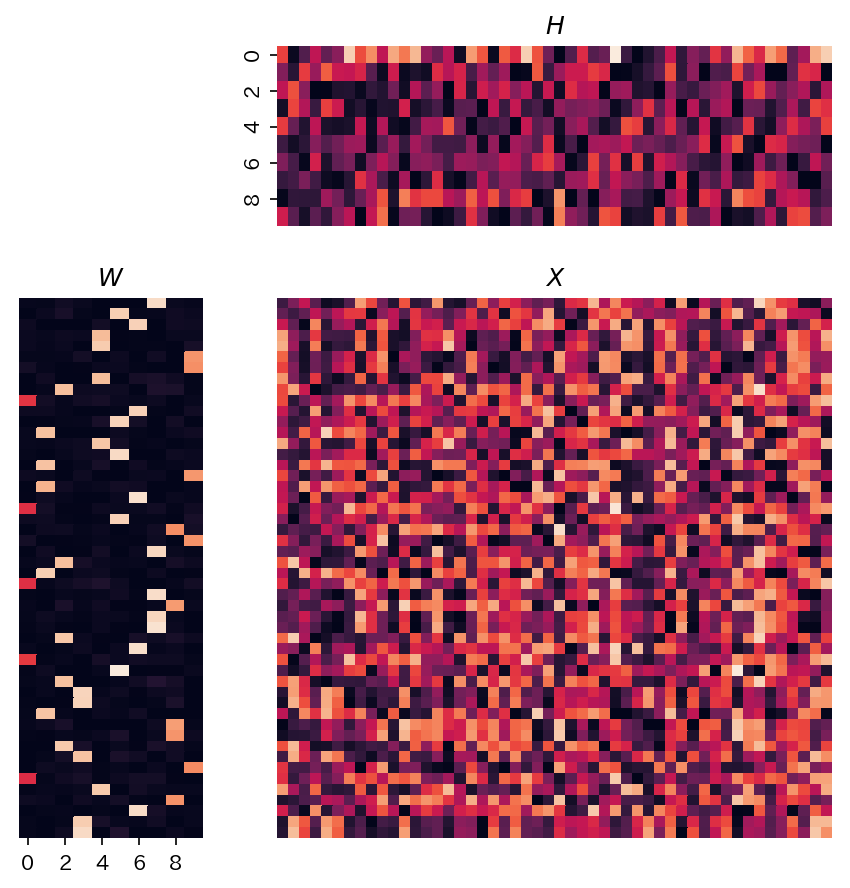

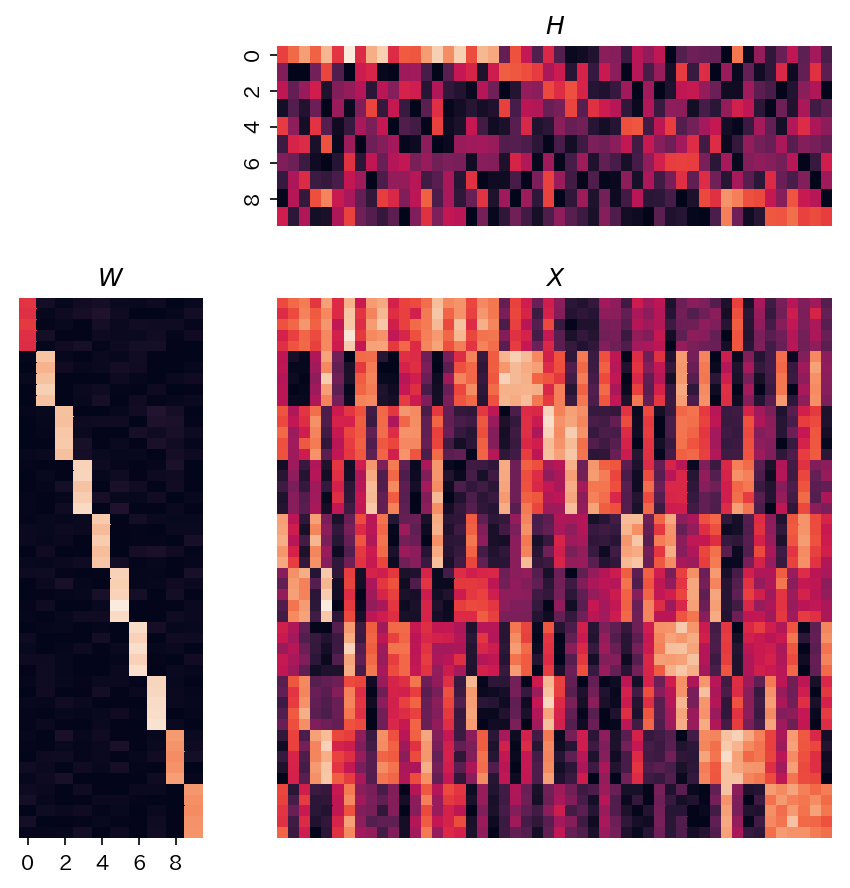

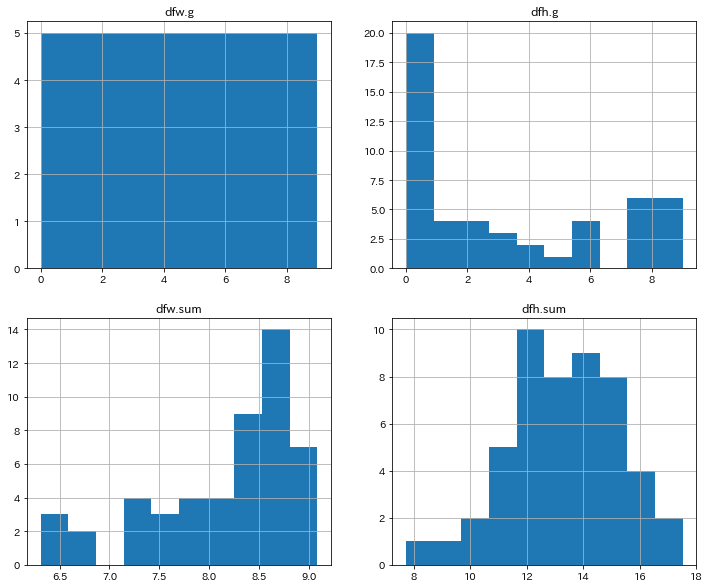

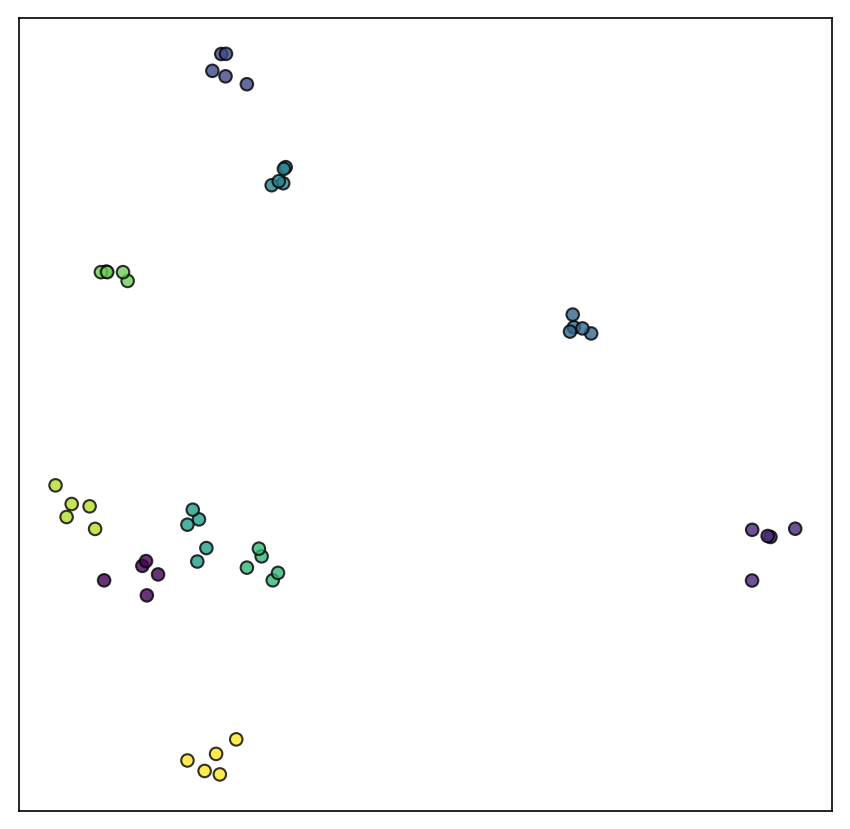

In [6]:
N, dim = [50] * 2
K = 10
X, dfw, dfh, rind, cind = nmf_demo(N=N, dim=dim, K=K, std=1, cmap=None)

## prepare dataset for demonstration

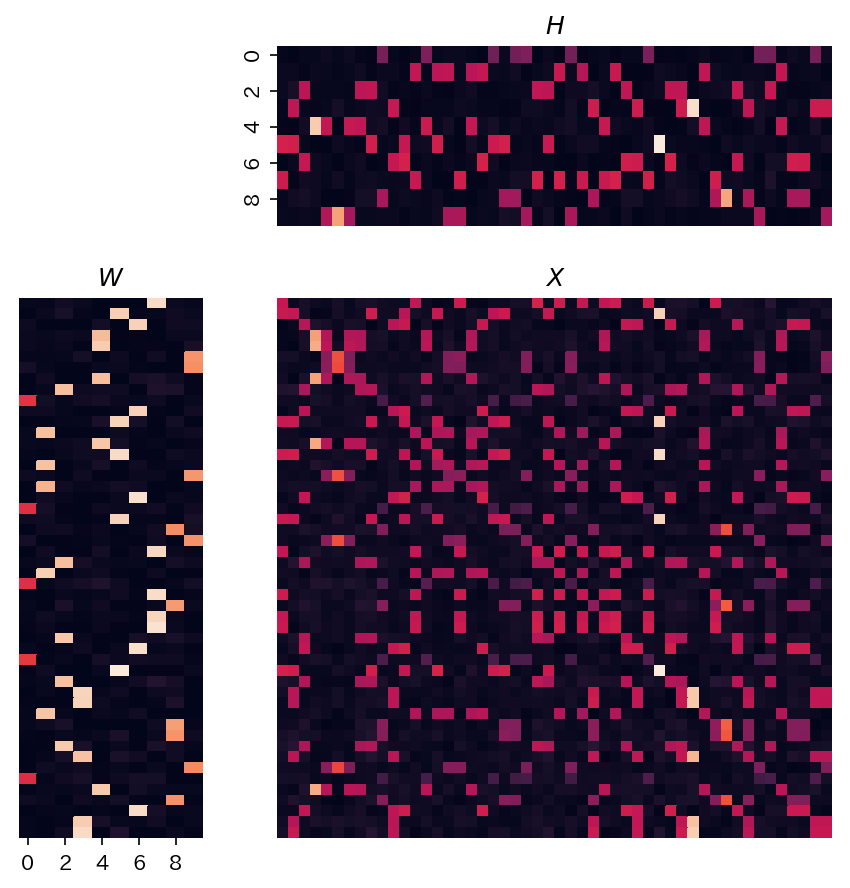

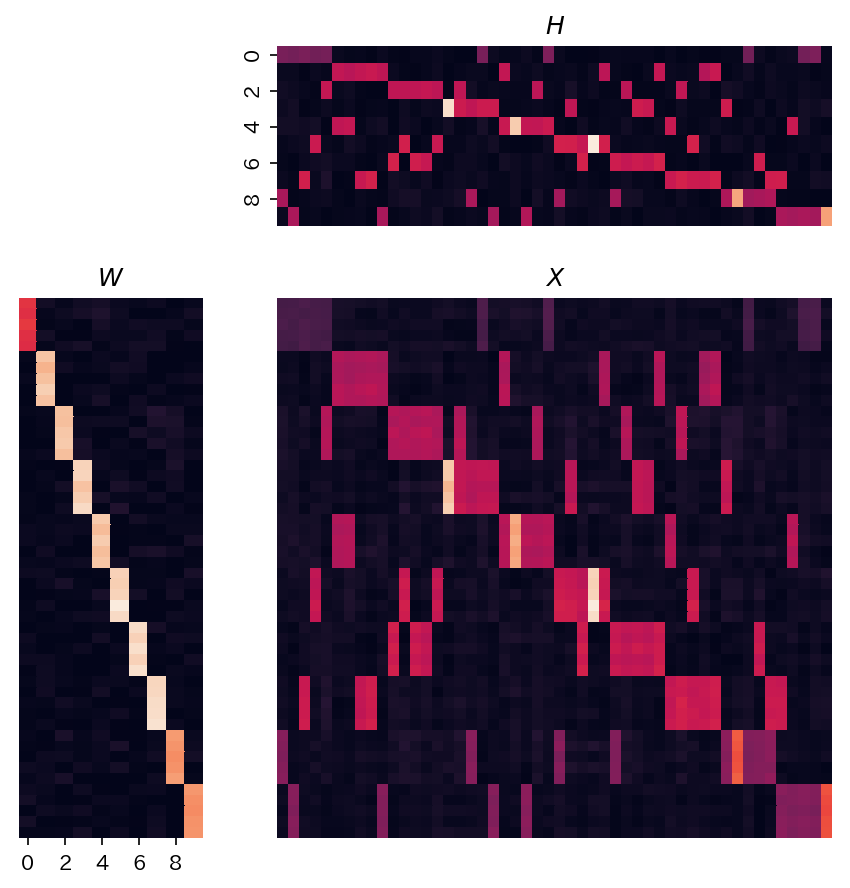

In [41]:
W = np.array(dfw.iloc[:,:K])
H = np.copy(W.transpose())

H += H[:, np.random.permutation(N)]
newX = np.dot(W, H)

heatmap_xwh(newX, W, H)
X_sorted = np.zeros_like(newX)
for i, r in enumerate(rind):
    for j, c in enumerate(rind):
        X_sorted[i,j] = newX[r,c]

heatmap_xwh(X_sorted, W[rind,:], H[:, rind])

### save

In [43]:
import json
with open('./docs/data.json', 'w') as fp:
    json.dump(dict(
        matrix=newX.tolist(),
        rgroup=dfw.g.tolist(),
        cgroup=dfw.g.tolist(),
        row_order=rind.tolist(),
        column_order=rind.tolist(),
        W=W.tolist(),
        H=H.tolist(),
        groups=K
    ), fp)

In [10]:
np.savetxt('docs/matrix.csv',X,delimiter=',')

In [5]:
def featureplot(f, types='steps', figsize=(5, 3)):
    x, N = f.shape
    xi = range(x)
    fig, ax = plt.subplots(N, 1, figsize=figsize, dpi=150)
    for i in range(N):
        y = f.iloc[:, i]
        if types == 'steps':
            ax[i].plot(xi, y, 'g', drawstyle=types)
            ax[i].set_ylim(-1, max(y)+1)
        elif types == 'vlines':
            ax[i].vlines(xi, 0, y, linewidth=.8, color='g')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.show()

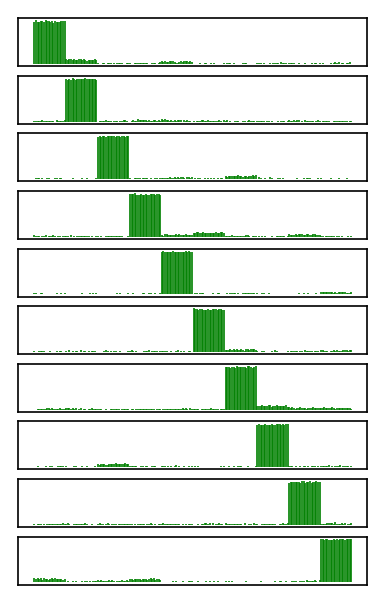

In [6]:
featureplot(dfw.iloc[rind, :K], 'vlines', figsize=(3, 5))

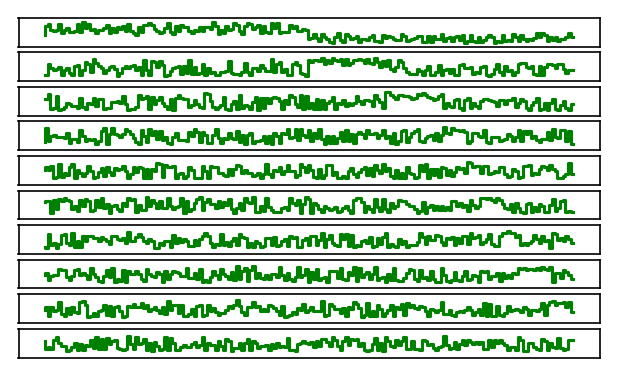

In [7]:
featureplot(dfh.iloc[cind, :K])